In [184]:
import pandas as pd 
import numpy as np
import networkx as nx
import pickle
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.spatial.distance as spsd
import scipy.linalg as spla
import sys
import random
import math
import itertools
from sklearn import linear_model



# Important requirements

1. Extra data/information to feed the model, e.g. national age/weight distribution(training data distribution 和 test data distribution不一样), body fat calculator


2. Data Preprocessing, data intrinsic link/relationship, Group/Cluster the data, outlier


3. Model selection: LR, Polynomial Regression, 


4. Shiny app


5. Body fat calculator, data imputation: https://www.active.com/fitness/calculators/bodyfat


6. model simplicity, 变量不全部用上，逐步回归，PCA（变量的线性组合），拟合多个模型，模型的解释性更强


7. 分布右偏，根据模型的分布进行模型的选择

In [185]:
data=pd.read_csv("/Users/app/Desktop/Madison_Course/STAT628/Module2/BodyFat.csv")
#weight_height=pd.read_csv("/Users/app/Downloads/500_Person_Gender_Height_Weight_Index.csv")

# Data Preprocess

In [186]:
data.head()

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,1,12.6,1.0708,23,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,2,6.9,1.0853,22,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,3,24.6,1.0414,22,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,4,10.9,1.0751,26,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,5,27.8,1.0340,24,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [ ]:
#age,weight,neck,abdomen,hip,thigh,forearm,wrist

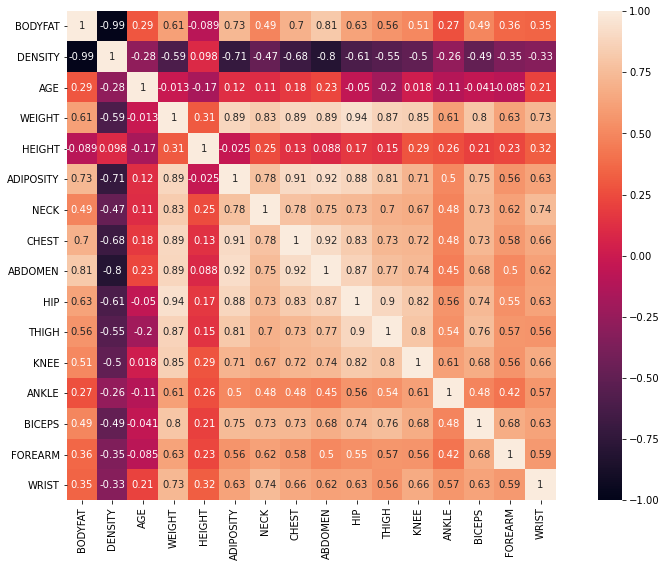

In [187]:
data_corr = data.drop('IDNO',axis=1).corr()
a = plt.subplots(figsize=(15,9))
a = sns.heatmap(data_corr, vmin=-1, vmax=1 , annot=True , square=True)

In [143]:
data.info()#there is no missing data (252 non-null)
data.describe().drop("count",axis=0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IDNO       252 non-null    int64  
 1   BODYFAT    252 non-null    float64
 2   DENSITY    252 non-null    float64
 3   AGE        252 non-null    int64  
 4   WEIGHT     252 non-null    float64
 5   HEIGHT     252 non-null    float64
 6   ADIPOSITY  252 non-null    float64
 7   NECK       252 non-null    float64
 8   CHEST      252 non-null    float64
 9   ABDOMEN    252 non-null    float64
 10  HIP        252 non-null    float64
 11  THIGH      252 non-null    float64
 12  KNEE       252 non-null    float64
 13  ANKLE      252 non-null    float64
 14  BICEPS     252 non-null    float64
 15  FOREARM    252 non-null    float64
 16  WRIST      252 non-null    float64
dtypes: float64(15), int64(2)
memory usage: 33.6 KB


,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
mean,126.500000,18.938492,1.055574,44.884921,178.924405,70.148810,25.436905,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,72.890329,7.750856,0.019031,12.602040,29.389160,3.662856,3.648111,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,1.000000,0.000000,0.995000,22.000000,118.500000,29.500000,18.100000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,63.750000,12.800000,1.041400,35.750000,159.000000,68.250000,23.100000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,126.500000,19.000000,1.054900,43.000000,176.500000,70.000000,25.050000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,189.250000,24.600000,1.070400,54.000000,197.000000,72.250000,27.325000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,252.000000,45.100000,1.108900,81.000000,363.150000,77.750000,48.900000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


### Estimated bodyfat vs real bodyfat

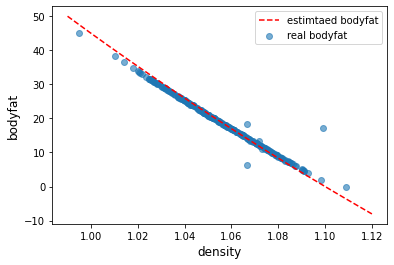

In [145]:
x=np.linspace(0.99,1.12,num=1000)
plt.plot(x,(495/x)-450,color='r',ls='--',label='estimtaed bodyfat')

plt.scatter(data["DENSITY"],data["BODYFAT"],alpha=0.6,label='real bodyfat')
plt.xlabel("density",fontsize=12)
plt.ylabel("bodyfat",fontsize=12)
plt.legend()

In [161]:
data.loc[abs((495/data['DENSITY']-450)-data['BODYFAT'])>2,]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
47,48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9
75,76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0,18.3
95,96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4
181,182,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5
215,216,45.1,0.9950,51,219.00,64.00,37.6,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


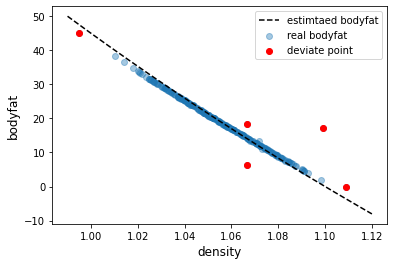

In [166]:
out=data.loc[abs((495/data['DENSITY']-450)-data['BODYFAT'])>2,]
x=np.linspace(0.99,1.12,num=1000)
plt.plot(x,(495/x)-450,color='black',ls='--',label='estimtaed bodyfat')

plt.scatter(data["DENSITY"],data["BODYFAT"],alpha=0.4,label='real bodyfat')
plt.scatter(out["DENSITY"], out["BODYFAT"], color="red",label='deviate point')
plt.xlabel("density",fontsize=12)
plt.ylabel("bodyfat",fontsize=12)
plt.legend()


## 1. ID=182 : Body fat = 0

In [188]:
data.loc[data['BODYFAT']==0.0]


,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
181,182,0.0,1.1089,40,118.5,68.0,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5


### Density is larger than 1.1, so calculated body fat will be less than 0.


#### 100 * Boday_Fat= (495/Density) -450

* Density>1.1, body_fat <0 

* Density<1.0, body_fat >45


In [190]:
data.loc[data['BODYFAT']==0.0,'BODYFAT']=8.0
data.loc[data["IDNO"]==182]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
181,182,8.0,1.1089,40,118.5,68.0,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5


## 2. ID=172 : Body fat = 1.9

In [191]:
data.loc[data['BODYFAT']==1.9]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
171,172,1.9,1.0983,35,125.75,65.5,20.6,34.0,90.8,75.0,89.2,50.0,34.8,22.0,24.8,25.9,16.9


## 3. ID=42 : Height Typo

In [192]:
data.loc[data['HEIGHT']==29.5]

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
41,42,31.7,1.025,44,205.0,29.5,29.9,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


### We use BMI to impute this value

BMI(kg/m^2) = Body Mass(kg) / (Body Height(m))^2

In [193]:
### 1 pound = 0.453592 kg
### 1 m = 39.3701 inches

data.loc[data['HEIGHT']==29.5]['WEIGHT']*0.453592/(data.loc[data['HEIGHT']==29.5]['ADIPOSITY'])

41    3.109912
dtype: float64

In [194]:
math.sqrt(3.109912)*39.3701

69.42894530922234

In [195]:
data.loc[data['HEIGHT']==29.5,"HEIGHT"]=69.5

# Model

 BIC instead of R^2 to evaluate the model

In [227]:
data_drop=data.drop(['IDNO','DENSITY'],axis=1)

In [228]:
clf = linear_model.Lasso(alpha=0.1)
clf.fit(data_drop.loc[:, data_drop.columns != 'BODYFAT'],data_drop['BODYFAT'])
#Lasso(alpha=0.1)
print(clf.coef_)
#[0.85 0.  ]
print(clf.intercept_)
#0.15...

[ 0.04645616 -0.09887424 -0.          0.08915009 -0.39985826 -0.02102112
  0.87149188 -0.14684546  0.19580645  0.          0.04401083  0.14021728
  0.33562855 -1.14390766]
-22.313322277246733


In [212]:
#print(clf.summary())
import statsmodels.api as sm
#X = sm.add_constant(X.ravel())
results = sm.OLS(data_drop['BODYFAT'],data_drop.loc[:, data_drop.columns != 'BODYFAT']).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                BODYFAT   R-squared (uncentered):                   0.964
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              458.1
Date:                Thu, 14 Oct 2021   Prob (F-statistic):                   2.92e-163
Time:                        06:17:40   Log-Likelihood:                         -698.66
No. Observations:                 252   AIC:                                      1425.
Df Residuals:                     238   BIC:                                      1475.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE            0.0582      0.030      1.953      0.052      -0.001       0.117
WEIGHT        -0.0434      0.023     -1.921      0.056      -0.088       0.001
HEIGHT        -0.1369      0.195     -0.703      0.482      -0.520       0.246
ADIPOSITY      0.0213      0.412      0.052      0.959      -0.791       0.833
NECK          -0.4886      0.213     -2.290      0.023      -0.909      -0.068
CHEST         -0.0751      0.098     -0.768      0.443      -0.268       0.117
ABDOMEN        0.8756      0.085     10.288      0.000       0.708       1.043
HIP           -0.2346      0.135     -1.743      0.083      -0.500       0.031
THIGH          0.1998      0.134      1.486      0.138      -0.065       0.465
KNEE          -0.0192      0.229     -0.084      0.933      -0.470       0.432
ANKLE          0.1212      0.208      0.583      0.561      -0.288       0.531
BICEPS         0.1568      0.159      0.984      0.326      -0.157       0.471
FOREARM        0.4077      0.185      2.203      0.029       0.043       0.772
WRIST         -1.5867      0.491     -3.230      0.001      -2.554      -0.619
==============================================================================
Omnibus:                        3.725   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.155   Jarque-Bera (JB):                2.535
Skew:                          -0.030   Prob(JB):                        0.281
Kurtosis:                       2.512   Cond. No.                         575.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [226]:
results = sm.OLS(data_drop['BODYFAT'],data_drop.loc[:, data_drop.columns != 'BODYFAT'],).fit_regularized(alpha=1, L1_wt=1)
regularized_regression_parameters = results.params
print(regularized_regression_parameters) 

AGE          0.145526
WEIGHT       0.118562
HEIGHT      -0.155440
ADIPOSITY    0.445001
NECK        -0.204864
CHEST        0.027419
ABDOMEN      0.070569
HIP         -0.063591
THIGH        0.011807
KNEE        -0.064843
ANKLE       -0.045059
BICEPS       0.004675
FOREARM      0.000000
WRIST       -0.089295
dtype: float64


In [224]:
print(results.params)

[ 3.38115652e-02 -3.38242668e-02 -2.61677967e-01  3.24761942e-04
 -4.20011184e-01 -5.82851613e-02  8.11571100e-01 -1.89873523e-01
  1.61494340e-01 -3.69620386e-02 -4.45642748e-02  9.00240433e-02
  1.74017320e-01 -4.08298543e-01]


In [ ]:
#data_drop.loc[:, ~data_drop.columns.isin(['b'])]
#data_drop.loc[:, data_drop.columns != 'BODYFAT']


In [73]:
print(list(data.columns))#.index("ABDOMEN")
#data.loc[:,data.columns[[9]]]
print(data.columns[[3,4,5,8,9,10]])

['IDNO', 'BODYFAT', 'DENSITY', 'AGE', 'WEIGHT', 'HEIGHT', 'ADIPOSITY', 'NECK', 'CHEST', 'ABDOMEN', 'HIP', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS', 'FOREARM', 'WRIST', 'HEIGHT_cm', 'WEIGHT_kg']
Index(['AGE', 'WEIGHT', 'HEIGHT', 'CHEST', 'ABDOMEN', 'HIP'], dtype='object')


In [74]:
kmeans_pre = KMeans(n_clusters=2, random_state=0).fit(weight_height.loc[:,weight_height.columns[[1,2]]])


In [79]:
#weight_height
weight_height['Gender_dummy'] = np.where(weight_height['Gender']== 'Male', 1, 0)

weight_height['Gender_dummy']==kmeans_pre.labels_

250

In [48]:
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=2, random_state=0).fit(data.loc[:,data.columns[[3,4,5,8,9,10]]])
kmeans.labels_
#array([1, 1, 1, 0, 0, 0], dtype=int32)
#>>> kmeans.predict([[0, 0], [12, 3]])
#array([1, 0], dtype=int32)
#>>> kmeans.cluster_centers_
#array([[10.,  2.],
     #  [ 1.,  2.]])

array([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0], dtype=int32)

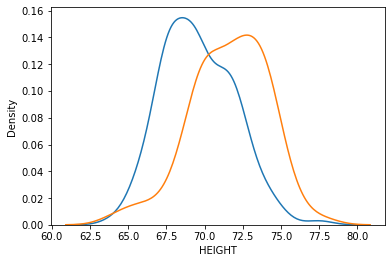

In [49]:
sns.kdeplot((data.iloc[kmeans.labels_==1,:])['HEIGHT'])
sns.kdeplot((data.iloc[kmeans.labels_==0,:])['HEIGHT'])

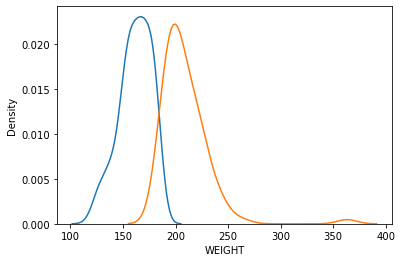

In [50]:
sns.kdeplot((data.iloc[kmeans.labels_==1,:])['WEIGHT'])
sns.kdeplot((data.iloc[kmeans.labels_==0,:])['WEIGHT'])

Text(0, 0.5, 'HEIGHT')

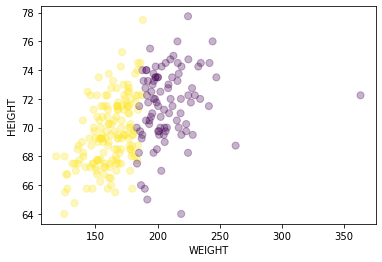

In [51]:
X=data.loc[:,data.columns[[4,5]]]
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans.labels_, s=50, cmap='viridis',alpha=0.3)
plt.xlabel(data.columns[4])
plt.ylabel(data.columns[5])

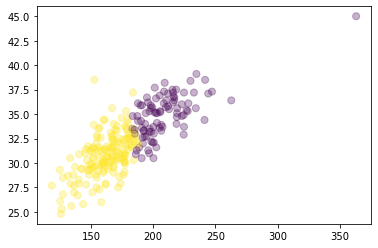

In [52]:
X=data.loc[:,data.columns[[4,14]]]
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans.labels_, s=50, cmap='viridis',alpha=0.3)
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)